In [1]:
#THIS IS THE MAIN FILE FOR TRAINING
#TODO SAN landmarks
#TODO: first few iterations of spectrogram and last few iterations of mel spectrogram


#Step1 
# reading video data
import random
random.seed(5)
import numpy as np
np.random.seed(5)
import os
os.environ['PYTHONHASHSEED']=str(5)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
import tensorflow as tf
tf.random.set_seed(5)

import scipy.io as scio
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D,Conv3D, MaxPooling3D, concatenate, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Input, LayerNormalization
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import optimizers

from keras.utils import to_categorical
from IPython.display import clear_output
from librosa.effects import preemphasis
from librosa.core import piptrack
#import tensorflow_probability as tfp
batch_size=32

Using TensorFlow backend.


In [2]:
#read videos and audio as training data for my own video encoder. If using vgg net check next cell
#step2
from os import listdir
from os.path import isfile, join, getmtime
from scipy.io import wavfile
from sklearn import preprocessing
from librosa import feature, effects
from scipy.signal import savgol_filter
#to play audio
from IPython.display import Audio 


import parselmouth
from parselmouth.praat import call

freq=25

#parameters than need to be tuned
shp=16384 #length of audio from each video. This is the minimum.- 9600
frameWidth=2
frameHeight=29 #68
frameCount=80 #50 before or 80
maxCount=1;

###############################
#pad video with 0 or interpolation
pad_video=False # false = interpolation
#stretch or pad audio with 0s
pad_audio=0 # 0 = stretch
#optflow or SAN or aligned face
opt=2 # 3: aligned+landmark 2: aligned+optflow, 1: optflow, 0: landmarks
mel_w=0 #weight on the mel term in spec loss
data_augment=False
normalize_video=False # make landmarks -1 to 1
include_style=False

region=2 # 0: jaw,  1: mouth only, 2: both for landmark indices
##########################

Xtrain=[]
Xtrain_aud=[]

Xtrain_aug=[]


newstyles=np.load('styles_1100.mat.npy')
newstyles=newstyles-1 #change the range from 1-2 to 0-1

filelist=np.load('filelist_1100.mat.npy')
print(np.shape(filelist)[0])
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler_std= preprocessing.StandardScaler()
scaler_max= preprocessing.MaxAbsScaler()
for i in range(np.shape(filelist)[0]):
    if (opt==1):
        vfile=filelist[i]+'_optflow.npy'
    elif (opt==2):
        vfile=filelist[i]+'_aligned.npy'
    elif (opt==3):
        vfile=filelist[i]+'_aligned_landmarks2.npy'
    else:
        vfile=filelist[i]+'_landmarks.npy'
    afile=filelist[i]+'_audio.wav'
    
    #_both.wmv contains both audio and video
    print(vfile)
    sr,aud = wavfile.read(afile)
    #image is of shape timepts x landmark pts x 1 x coordinates e.g. (28, 68, 2)
    image1=np.load(vfile)

    image=[]
    image_aug=[]
    for tp in range(np.shape(image1)[0]):
        #tp x landmarks x coordinates
        # measurements based on nose center point 33
        #normalize based on distance between the eyes and eye: 45 and 39
        #normalize basedon distance between eye and nose: 33 and 27
        if region==2:
            landmarks_indices=[*range(4,13),*range(48,68)] #5:13 is lower jaw and 49:68 is lips
        elif region ==1:
            landmarks_indices=[*range(48,68)] #mouth only
        elif region ==0:
            landmarks_indices=[*range(4,13)] #jaw only
        
        #for x-axis
        tempX = np.float32(image1[tp,landmarks_indices,0] - image1[tp,33,0])/(image1[1,45,0] - image1[1,39,0])
        
        augX=  np.float32(image1[tp,33,0] - image1[tp,landmarks_indices,0])/(image1[1,45,0] - image1[1,39,0])
        #for y-axis
        tempY = np.float32(image1[tp,landmarks_indices,1] - image1[tp,33,1])/(image1[1,33,1] - image1[1,27,1])
        if(tp==0):
            firstX=tempX
            firstY=tempY
            augfirstX=augX

        image.append(np.concatenate((tempX-firstX,tempY-firstY), axis=0))
        if data_augment:
            image_aug.append(np.concatenate((augX-augfirstX,tempY-firstY), axis=0))
    

    #because cv has width x height and numpy is heightxwidth
    dim = (np.shape(landmarks_indices)[0]*2,frameCount)
    # resize image
    if pad_video:
        if 0:
            offset= np.int(np.round((frameCount-np.shape(image)[0])/2))
            hsv=np.zeros((frameCount,frameHeight*frameWidth));
            hsv[offset:offset+np.shape(image)[0],:]=image
        else:
            
            hsv=np.pad(image,((0, frameCount-np.shape(image)[0]),(0,0)), mode='edge')
            if data_augment:
                hsv_aug=np.pad(image_aug,((0, frameCount-np.shape(image)[0]),(0,0)), mode='edge')
            #print(np.shape(image),np.shape(hsv))
        
    else:
        #(56, 58) (64, 58)
        hsv = cv2.resize(np.float32(image), dim, interpolation = cv2.INTER_CUBIC)
        if data_augment:
            hsv_aug = cv2.resize(np.float32(image_aug), dim, interpolation = cv2.INTER_CUBIC)
            
        
    #plt.subplot(2,1,1)
    #plt.plot(hsv)
    for lp in range(np.shape(hsv)[1]):
        #smooth the video data: TODO - play with window size
        yhat = savgol_filter(hsv[:,lp], 5, 4) # window size 35, polynomial order 3
        hsv[:,lp] = yhat
    
    if data_augment:
        for lp in range(np.shape(hsv_aug)[1]):
            #smooth the video data: TODO - play with window size
            yhat = savgol_filter(hsv_aug[:,lp], 5, 4) # window size 35, polynomial order 3
            hsv_aug[:,lp] = yhat

        Xtrain_aug.append(hsv_aug) 
    #plt.subplot(2,1,2)
    #plt.plot(hsv)

        
    print(np.shape(image), np.shape(hsv), sr)
    # append the next video file
    if normalize_video:
        test=scaler_std.fit_transform(hsv)
        Xtrain.append(test)
    else:
        Xtrain.append(hsv)#np.nan_to_num(buf)
    #convert stereo to mono
    #aud=aud[1] # use this if you do not need sampling rate
    #adjust the size of audio
    
    #remove silence from the audio
    aud, index=effects.trim(np.float32(aud), top_db=freq)
    #duration can act as another feature
    duration = np.shape(aud)[0]
    #hack to get the sizes correct
    aud=np.append(aud,np.zeros([1024]))
    if (pad_audio==1):
        if(shp > np.shape(aud)[0]):
            aud = np.pad(np.float32(aud), (0, shp-np.shape(aud)[0]), 'constant', constant_values=(0, 0))
        else:
            aud = aud[0:shp]
    else:
        #either this (not so good)
        #aud =effects.time_stretch(np.float32(aud), np.shape(aud)[0]/shp)
        #or this
        #sound = parselmouth.Sound(afile)
        sound = parselmouth.Sound(aud.T, sampling_frequency=sr)
        #create manipulation object
        manipulation = call(sound, "To Manipulation",0.01, 50, 200)

        ##extract durationtier and add a duration point
        duration_tier = call(manipulation, "Extract duration tier")
        duration = call(duration_tier, "Add point", sound.end_time, shp/(np.shape(aud)[0]*1.0))

        #replace the duration tier in the manipulation object
        call([duration_tier, manipulation], "Replace duration tier")

        #Publish resynthesis
        sound_octave_up = call(manipulation, "Get resynthesis (overlap-add)")
        
        aud=sound_octave_up.values.T
        #if(sound_octave_up.n_samples < shp):
        #    aud=np.pad(aud[:,0],np.round((shp-sound_octave_up.n_samples)/2).astype('int32') ,mode='wrap')
    len_aud=np.shape(aud)[0]

    #if(len_aud<16384):
    #    ##pad adds in both directions
    #    #aud=np.pad(aud,16384-len_aud,mode='wrap')
    #    ##we want to pad at the end only
    #    #print(np.shape(aud))
    #    aud=np.concatenate([aud, np.zeros(shp-len_aud)])
    aud=np.reshape(aud[0:shp],(shp,1))
    #standarize the data to be between -1 to +1
    #aud=scaler.fit_transform(aud)
    aud=scaler_std.fit_transform(aud)
    aud=scaler_max.fit_transform(aud)
    Xtrain_aud.append(aud)
np.shape(Xtrain_aud)


if include_style:
    styles=np.tile(newstyles, (1,80, 1))
    Xtrain=np.append(Xtrain, np.reshape(styles,(1349,80,1)) , axis=2)


newlabels=np.load('labels_1100.mat.npy')

#Xtrain shape - 1349 (subj) x 50 (time points) x 58 (x and y coordinates)

1349
scratch/avc/lisa_data_opt/1101/1101_part1_cod_1396.0_1437.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_cod_1663.0_1709.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_kid_3023.0_3064.0_mouth_aligned.npy
(62, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_kid_3227.0_3268.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_cooed_3475.0_3514.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_cooed_3697.0_3742.0_mouth_aligned.npy
(64, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_keyed_3937.0_3973.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_keyed_4169.0_4213.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_could_4891.0_4925.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part1_cud_6520.0_6556.0_mouth_a

(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_could_13103.0_13138.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_could_13264.0_13300.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_kid_15158.0_15189.0_mouth_aligned.npy
(39, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_kid_15377.0_15415.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_cod_16010.0_16048.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_cod_16159.0_16201.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_keyed_17086.0_17123.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_keyed_17294.0_17339.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part2_cooed_17498.0_17537.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101

(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_could_27493.0_27529.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_keyed_27673.0_27712.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_keyed_27929.0_27973.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_kid_29587.0_29621.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1101/1101_part3_kid_29743.0_29787.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part1_cod_13189.0_13234.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part1_cod_13520.0_13565.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part1_kid_14699.0_14740.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part1_kid_14890.0_14931.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/110

scratch/avc/lisa_data_opt/1102/1102_part2_cud_12607.0_12652.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_could_12818.0_12862.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_could_12971.0_13018.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_kid_14891.0_14935.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_kid_15083.0_15129.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_cod_15694.0_15741.0_mouth_aligned.npy
(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_cod_15823.0_15873.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_keyed_16769.0_16815.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_keyed_16952.0_17002.0_mouth_aligned.npy
(66, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part2_cooed_17252.0_

(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_cud_25438.0_25483.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_could_25708.0_25751.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_could_25876.0_25923.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_keyed_26158.0_26203.0_mouth_aligned.npy
(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_keyed_26467.0_26518.0_mouth_aligned.npy
(62, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_kid_28606.0_28648.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1102/1102_part3_kid_28754.0_28798.0_mouth_aligned.npy
(60, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part1_cod_2864.0_2902.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part1_cod_3097.0_3135.0_mouth_aligned.npy
(41, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_

scratch/avc/lisa_data_opt/1103/1103_part3_kid_8110.0_8146.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_kid_8258.0_8296.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cud_8717.0_8757.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cud_8893.0_8932.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cooed_9461.0_9502.0_mouth_aligned.npy
(57, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cooed_9611.0_9653.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_cud_10124.0_10162.0_mouth_aligned.npy
(42, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_keyed_10271.0_10312.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_keyed_10414.0_10455.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1103/1103_part3_could_10594.0_10631.0_mout

(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_cooed_1925.0_1977.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_keyed_2791.0_2837.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_keyed_2965.0_3016.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_cud_5108.0_5147.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_cud_5332.0_5373.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_could_6085.0_6125.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_could_6254.0_6298.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_kid_6586.0_6628.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_could_7139.0_7181.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part2_coul

(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_keyed_15772.0_15823.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_could_15974.0_16017.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_kid_17293.0_17333.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_kid_17456.0_17500.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_cod_17630.0_17675.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_cod_18121.0_18166.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_cud_20609.0_20651.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_cud_20770.0_20813.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_part3_kid_20960.0_21001.0_mouth_aligned.npy
(56, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1104/1104_

(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cud_21064.0_21101.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cud_21197.0_21235.0_mouth_aligned.npy
(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cod_21484.0_21526.0_mouth_aligned.npy
(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cod_21620.0_21652.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cooed_21782.0_21825.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part2_cooed_21922.0_21963.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_kid_1526.0_1565.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_kid_1645.0_1689.0_mouth_aligned.npy
(57, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part3_cooed_1822.0_1867.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1105/1105_part

(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_cod_11779.0_11819.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_cod_11999.0_12041.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_cud_12196.0_12233.0_mouth_aligned.npy
(41, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_cud_12382.0_12419.0_mouth_aligned.npy
(47, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_kid_12971.0_13011.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_kid_13156.0_13193.0_mouth_aligned.npy
(40, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_could_14905.0_14945.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_could_15079.0_15118.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part1_keyed_15292.0_15335.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/110

scratch/avc/lisa_data_opt/1106/1106_part2_keyed_19091.0_19129.0_mouth_aligned.npy
(45, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_could_20662.0_20701.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_could_20806.0_20842.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cud_20965.0_21003.0_mouth_aligned.npy
(41, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cud_21107.0_21145.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cod_21400.0_21436.0_mouth_aligned.npy
(39, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cod_21547.0_21586.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cooed_21709.0_21747.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part2_cooed_21848.0_21879.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1106/1106_part3_kid_1660.0_1

(67, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_keyed_12578.0_12621.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_keyed_12727.0_12778.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_cod_12923.0_12965.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_cod_13151.0_13209.0_mouth_aligned.npy
(70, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_cud_13358.0_13397.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_cud_13634.0_13683.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_kid_14222.0_14263.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_kid_14420.0_14458.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part1_could_16535.0_16576.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/110

(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_cod_23263.0_23311.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_kid_23792.0_23833.0_mouth_aligned.npy
(51, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_keyed_24376.0_24421.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_keyed_24496.0_24550.0_mouth_aligned.npy
(72, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_could_26794.0_26835.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_could_26998.0_27043.0_mouth_aligned.npy
(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_cud_27263.0_27303.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_cud_27424.0_27472.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1107_part2_cod_27874.0_27916.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1107/1

(57, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_kid_6626.0_6663.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cud_7223.0_7252.0_mouth_aligned.npy
(38, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cud_7357.0_7395.0_mouth_aligned.npy
(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cooed_9538.0_9579.0_mouth_aligned.npy
(58, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cooed_9722.0_9765.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_keyed_9937.0_9979.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_keyed_10064.0_10108.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cod_10244.0_10288.0_mouth_aligned.npy
(59, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cod_10417.0_10461.0_mouth_aligned.npy
(63, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part1_cu

(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cooed_16165.0_16210.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_could_16894.0_16931.0_mouth_aligned.npy
(41, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cud_17326.0_17363.0_mouth_aligned.npy
(52, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cod_17468.0_17511.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_cod_17593.0_17635.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_keyed_18587.0_18629.0_mouth_aligned.npy
(57, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_keyed_18709.0_18754.0_mouth_aligned.npy
(61, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_could_20378.0_20415.0_mouth_aligned.npy
(40, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1109/1109_part2_could_20503.0_20543.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/11

scratch/avc/lisa_data_opt/1110/1110_part1_could_5426.0_5461.0_mouth_aligned.npy
(42, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_could_5572.0_5609.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_kid_6169.0_6203.0_mouth_aligned.npy
(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cud_6799.0_6832.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cud_6950.0_6989.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cooed_8842.0_8881.0_mouth_aligned.npy
(53, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cooed_8996.0_9043.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_keyed_9197.0_9237.0_mouth_aligned.npy
(48, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_keyed_9311.0_9358.0_mouth_aligned.npy
(50, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part1_cod_9484.0_9521.0_mouth_alig

(54, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_keyed_16979.0_17015.0_mouth_aligned.npy
(49, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_keyed_17119.0_17163.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cooed_17296.0_17327.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cooed_17429.0_17476.0_mouth_aligned.npy
(60, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_could_18170.0_18203.0_mouth_aligned.npy
(36, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cud_18566.0_18601.0_mouth_aligned.npy
(43, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cod_18686.0_18724.0_mouth_aligned.npy
(46, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_cod_18821.0_18868.0_mouth_aligned.npy
(55, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110/1110_part2_kid_19252.0_19285.0_mouth_aligned.npy
(37, 58) (80, 58) 16000
scratch/avc/lisa_data_opt/1110

In [25]:
test=cm(0)
print(test,test[2])


(1.0, 0.0, 0.16, 1.0) 0.16


(1349, 80, 58)


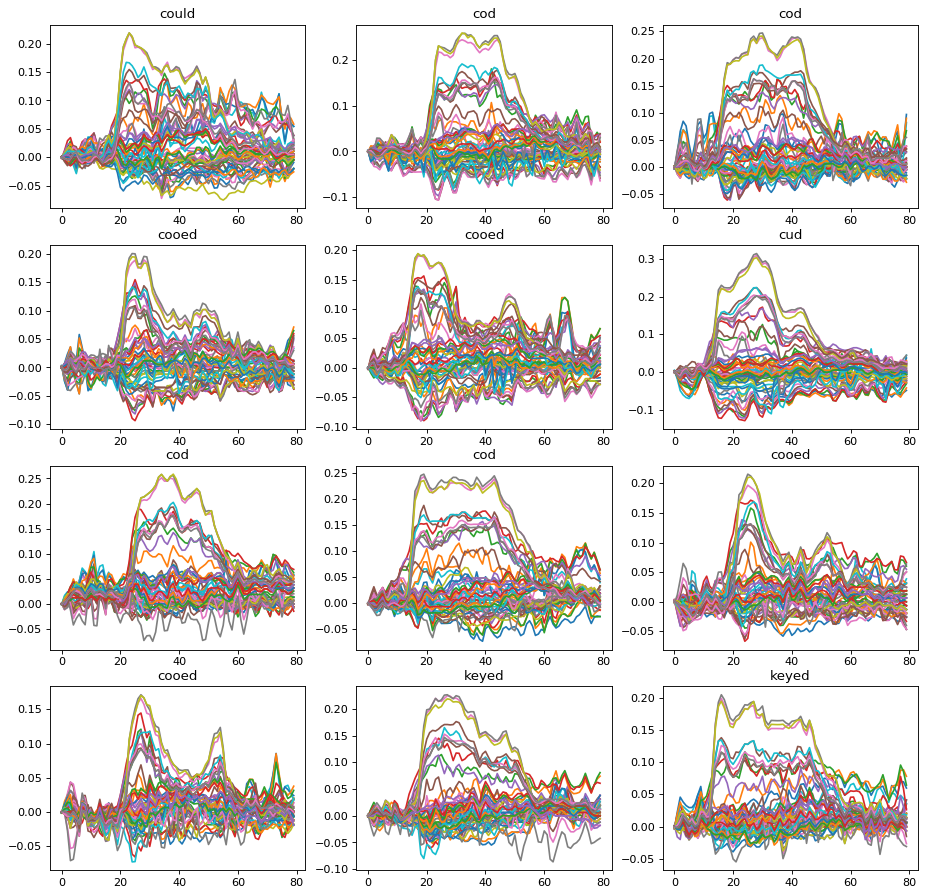

In [5]:
#pad video with 0 instead of interpolation

#JawX=*range(0,9)
#LipsX=*range(9,29) #9-48, #15-54, 
#JawY=*range(29,38)
#LipsY=*range(38,58)# #41-51, #47-57

landmarks_indices=[*range(4,13),*range(48,68)] #5:13 is lower jaw and 49:68 is lips
tempX = np.float32(image1[tp,landmarks_indices,0] - image1[tp,33,0])/(image1[1,45,0] - image1[1,39,0])
        
print(np.shape(Xtrain)) # subjects x time x landmark locations
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
for num in range(212,224):
    plt.subplot(4,3,num-211)
    if 0:
        test=scaler_std.fit_transform(Xtrain[num])
    else:
        test =Xtrain[num]
    #plt.plot(test[:,[9,15,41,47]])
    plt.plot(test)
    #plt.xlabel('Time - frame number')
    #plt.ylabel('movements in pixels')
    plt.title(filelist[num].split('/')[4].split('_')[2])
    #plt.gca().legend(('Lips-49-x','Lips-55-x','Lips-52-y','Lips-58-y'))

128 32 512
(509, 257) 257


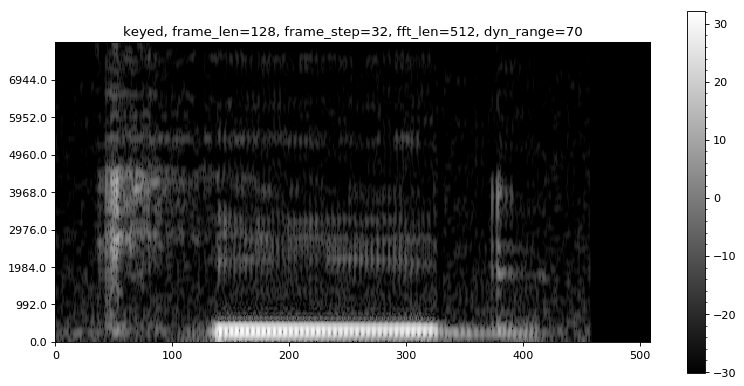

In [3]:
#step 3
#plot spectrogram
#55 for subj1
#52 for sub2
#44 for sub3
sr=16000


#winlen=0.02,
#winstep=0.025,

_LOG_EPS = 1e-6
frame_length= 128 # np.int32(sr*0.005) #window len - 80
frame_step=np.int32(np.round(sr*0.002)) # time step -32 - increase value decreases X-ticks - 0.002 or 0.006
fft_len=512 # increase value increases y ticks 
epochs=2500
fac = fft_len/16

#from griffin lim paper: https://ieeexplore.ieee.org/document/1164317
#if the window length (L) is a multiple of four times the window shift (S)

print(frame_length, frame_step, fft_len)
apply_pre_emp=False
if apply_pre_emp:
    alpha=0.8
    dyn_range=35
else:
    alpha=0.8
    dyn_range=70
apply_reg=False

def get_spectrogram(waveform):
    
    stfts = tf.signal.stft(np.float32(np.transpose(waveform)), frame_length, frame_step,fft_length=fft_len, pad_end=False)
    spectrograms = tf.abs(stfts)
    spec_pred_db=10*tf.math.log(spectrograms + _LOG_EPS)
    
    #adjust dynamic range
    mx=tf.math.reduce_max(spec_pred_db)
    spec_pred_db= tf.clip_by_value(spec_pred_db, mx-dyn_range, mx)
    spect = tf.nn.leaky_relu(spec_pred_db, alpha=alpha) 
    return spect
    
def get_mel_spec(waveform):
    
    #The window-size, hop-size and mel dimension are 800, 200, and 80 respectively.
    
    stfts = tf.signal.stft(np.float32(np.transpose(waveform)), frame_length, frame_step,fft_length=fft_len, pad_end=False)
    spectrograms = tf.abs(stfts)


    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 10.0, 3000.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))
    spect = mel_spectrograms
    print(np.shape(mel_spectrograms))
    return spect


#nfft =1024 # sr/20; # fs/freq_step = 800
#3: coed
#4: keyed
#49 keyed
#48 cooed
#104 keyed

fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')

spec_cooed=[]
spec_keyed=[]
spec_cod=[]
for no in range(10):
    sno=0+no
    #print(filelist[sno])
    waveform=Xtrain_aud[sno][:,0]
    #print(np.shape(waveform))
    ## pre emphasis filtering
    if apply_pre_emp:
        pre = np.append(waveform[0], waveform[1:] - 0.97 * waveform[:-1])
    else:
        pre=waveform

    #waveform=waveform[2500:16384,:]
    
    if 1:
        stfts = tf.signal.stft(np.float32(np.transpose(pre)), frame_length, frame_step,fft_length=fft_len, pad_end=False)
        spectrograms = tf.abs(stfts)

        spec_pred_db=10*tf.math.log(spectrograms + _LOG_EPS)
        #print(np.shape(spec_pred_db))
        if 1:
            if no==0:
                avg_spec = tf.abs(spec_pred_db)
            else:
                avg_spec = avg_spec+tf.abs(spec_pred_db)

        if(newlabels[sno]=='keyed'):
            spec_keyed.append(spec_pred_db)
        if(newlabels[sno]=='cooed'):
            spec_cooed.append(spec_pred_db)
        if(newlabels[sno]=='cod'):
            spec_cod.append(spec_pred_db)



        mx=tf.math.reduce_max(spec_pred_db)
        spec_pred_db= tf.clip_by_value(spec_pred_db, mx-dyn_range, mx)
        spec_pred_db = tf.nn.leaky_relu(spec_pred_db, alpha=alpha)
        #spec_pred_db=mel_spectrograms
    else:
        spec_pred_db=get_mel_spec(waveform)
    
    
    
    # for plotting
    if apply_reg==False:
        if sno==6:
            #plt.subplot(5,3,no+1)
            plt.imshow(np.transpose(spec_pred_db[:,:]),origin='lower', cmap='gray')
            locs, labels = plt.yticks()
            val=np.shape(spec_pred_db)[1]
            print(np.shape(spec_pred_db),val)
            plt.yticks(fac*np.arange(8),fac*np.round(0.5*sr/val)*np.arange(8))
            lab=newlabels[sno]
            plt.title(lab[0]+", frame_len="+ str(frame_length)+", frame_step="+str(frame_step)+", fft_len="+str(fft_len)+", dyn_range="+str(dyn_range))
            cbar = plt.colorbar()
            cbar.minorticks_on()

    else:
        avg_spec=avg_spec/120
        plt.imshow(np.transpose(avg_spec[:,:]),origin='lower', cmap='gray')
        locs, labels = plt.yticks()
        val=np.shape(avg_spec)[1]
        plt.yticks(100*np.arange(np.round(val/100)),100*np.round(sr/val)*np.arange(np.round(val/100)))
        plt.title('Average Spectrogram')


        cbar = plt.colorbar()
        cbar.minorticks_on()


In [4]:
#step 4
#spec loss
import keras.backend as K
from librosa import util
from scipy.signal import get_window

_LOG_EPS = 1e-6
samp_rate=sr
nfft = fft_len

#frame_length=1024#np.int32(samp_rate*0.005) #window len
#frame_step=32#np.round(samp_rate*0.002) # time step
#nfft =1024 # sr/20; # fs/freq_step = 800

#Window len: 0.005s
#Max freq=5000Hz
#Time step= 0.002s
#Frequency step=20
#Window shape= gaussian

def tf_cov(ten):
    x = ten#tf.reshape(ten, [-1])
    mean_x = tf.reduce_mean(x, axis=0, keepdims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx

class changeAlpha(tf.keras.callbacks.Callback):
    beta=2
    def on_epoch_end(self, epoch, logs={}):
        self.beta = epoch
        #K.set_value(self.beta, K.get_value(epoch))

def mel_mse_loss(frame_step, fft_len):
    def mel_loss(y_true,y_pred):
        #y_pred shape (32, 16384, 1) y_true shape(32, 16384, 1)
        # make sure the input to the stft is batch_size x time points (2D) rather than bs x time points x 1
        mse = MeanSquaredError()
        #256,128
        waveform = y_pred[:,:,0]

        if apply_pre_emp:
            pre = tf.concat([tf.reshape(waveform[:,0],[batch_size,1]), waveform[:,1:] - 0.97 * waveform[:,:-1]], axis=1)
        else:
            pre=waveform
        stfts_pred = tf.signal.stft(pre, np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(fft_len),window_fn=tf.signal.hamming_window,pad_end=False)


        #stfts_pred = tf.signal.stft(y_pred[:,:,0], np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(nfft),window_fn=tf.signal.hamming_window,pad_end=False)
        spectrograms_pred = tf.math.abs(stfts_pred) 

        # Warp the linear scale spectrograms into the mel-scale.
        num_spectrogram_bins = stfts_pred.shape[-1]
        lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 7600.0, 100
        linear_to_mel_weight_matrix_pred = tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
          upper_edge_hertz)
        spec_pred_db = tf.tensordot(
          spectrograms_pred, linear_to_mel_weight_matrix_pred, 1)
        spec_pred_db.set_shape(spectrograms_pred.shape[:-1].concatenate(
          linear_to_mel_weight_matrix_pred.shape[-1:]))

        log_mel_spectrograms = tf.math.log(spec_pred_db + 1e-6)
        
        #batchsize x #mfccs x #mel bins
        #(32, 128, 80)
        mfccs_pred = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mel_bins]


        
        waveform = y_true[:,:,0]
        if apply_pre_emp:
            pre = tf.concat([tf.reshape(waveform[:,0],[batch_size,1]), waveform[:,1:] - 0.97 * waveform[:,:-1]], axis=1)
        else:
            pre=waveform
        stfts_true = tf.signal.stft(pre, np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(fft_len),window_fn=tf.signal.hamming_window,pad_end=False)


        #stfts_true = tf.signal.stft(y_true[:,:,0], np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(nfft),window_fn=tf.signal.hamming_window,pad_end=False)
        spectrograms_true = tf.math.abs(stfts_true) 

        # Warp the linear scale spectrograms into the mel-scale.
        num_spectrogram_bins = stfts_true.shape[-1]

        linear_to_mel_weight_matrix_true = tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
          upper_edge_hertz)
        spec_true_db = tf.tensordot(
          spectrograms_true, linear_to_mel_weight_matrix_true, 1)
        spec_true_db.set_shape(spectrograms_true.shape[:-1].concatenate(
          linear_to_mel_weight_matrix_true.shape[-1:]))
        
        log_mel_spectrograms = tf.math.log(spec_true_db + 1e-6)
        
        mfccs_true = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mel_bins]
        print(np.shape(mfccs_true))
        #debug
        #print(np.shape(spec_pred_db))
        #print(np.shape(spec_true_db))
        #print(np.shape(y_pred),np.shape(y_true))

        #if(np.shape(spec_true_db)[1] == 128):
            #plt.imshow(spec_true_db[1,:,:])
            #plt.imshow(spec_pred_db[1,:,:])
        return mse(mfccs_pred ,mfccs_true)
        #return K.mean(K.sum(K.square(K.abs(spec_pred_db - spec_true_db)), axis=1),axis=-1) 

    return mel_loss

# loss = w1 * low_res + w2 * mid_res + w3 * high_res
def spec_mse_loss(frame_step, fft_len):
    def spec_loss(y_true,y_pred):
        #y_pred shape (32, 16384, 1) y_true shape(32, 16384, 1)
        # make sure the input to the stft is batch_size x time points (2D) rather than bs x time points x 1

        #256,128
        waveform = y_pred[:,:,0]

        if apply_pre_emp:
            pre = tf.concat([tf.reshape(waveform[:,0],[batch_size,1]), waveform[:,1:] - 0.97 * waveform[:,:-1]], axis=1)
        else:
            pre=waveform
        spec_pred = tf.signal.stft(pre, np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(fft_len),window_fn=tf.signal.hamming_window,pad_end=False)
        X_mag_pred = tf.math.abs(spec_pred)     
        spec_pred_db = 10*tf.math.log(X_mag_pred + _LOG_EPS)
        if apply_reg:
            spec_reg_term = tf.abs(spec_pred_db)
        mx=tf.math.reduce_max(spec_pred_db)
        spec_pred_db= tf.clip_by_value(spec_pred_db, mx-dyn_range, mx)
        spec_pred_db = tf.nn.leaky_relu(spec_pred_db, alpha=alpha) # set negative values close to zero as we want to match bright regions only


        waveform = y_true[:,:,0]

        if apply_pre_emp:
            pre = tf.concat([tf.reshape(waveform[:,0],[batch_size,1]), waveform[:,1:] - 0.97 * waveform[:,:-1]], axis=1)
        else:
            pre=waveform
        spec_true = tf.signal.stft(pre, np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(fft_len),window_fn=tf.signal.hamming_window,pad_end=False)   
        X_mag_true = tf.math.abs(spec_true)
        spec_true_db = 10*tf.math.log(X_mag_true + _LOG_EPS)
        mx=tf.math.reduce_max(spec_true_db)
        spec_true_db= tf.clip_by_value(spec_true_db, mx-dyn_range, mx)
        spec_true_db = tf.nn.leaky_relu(spec_true_db, alpha=alpha)

        #debug
        #print(np.shape(spec_pred_db))
        #print(np.shape(spec_true_db))
        #print(np.shape(y_pred),np.shape(y_true))

        #if(np.shape(spec_true_db)[1] == 128):
            #plt.imshow(spec_true_db[1,:,:])
            #plt.imshow(spec_pred_db[1,:,:])

        #12 481 513
        #1,510,257 <-- with praat params
        if apply_reg:
            avg_spec_db = tf.nn.leaky_relu(avg_spec, alpha=alpha)
            X=tf.reshape(spec_reg_term,[batch_size,np.shape(spec_pred_db)[1]*np.shape(spec_pred_db)[2] ])
            Y=tf.reshape(avg_spec_db,[np.shape(spec_pred_db)[1]*np.shape(spec_pred_db)[2] ])
            #covY=tf_cov(Y)
            #temp=tf.matmul(tf.math.subtract(X,Y), tf.linalg.inv(covY))
            #term = 0.15*tf.matmul(temp, tf.math.subtract(X,Y))
            reg_term = 0.1*K.mean(K.sum(K.square(K.abs(spec_reg_term- avg_spec_db)), axis=1),axis=-1)
        else:
            reg_term=0
        mse = MeanSquaredError()
        
        spec_reshape=tf.expand_dims(spec_pred_db,axis=3)
        grad_image = tf.image.image_gradients(spec_reshape)
        grad_predict=grad_image[1] #along y axis
        print(np.shape(grad_image), np.shape(grad_predict))   
        spec_reshape=tf.expand_dims(spec_true_db,axis=3)
        grad_image = tf.image.image_gradients(spec_reshape)
        grad_true=grad_image[1] #along y axis
 
        #tf.config.experimental_run_functions_eagerly(True)
        #print(mse(spec_pred_db, spec_true_db).numpy(), mse(grad_predict, grad_true).numpy())
        
        #mse of spec is in 100s and mse of grad is in range 3
        #loss_mel = mel_mse_loss(np.int32(np.round(sr*0.002*4)), 128)
        loss_mel = mel_mse_loss(frame_step, fft_len)
        
        return 1*mse(grad_predict, grad_true)+mse(spec_pred_db, spec_true_db) +mel_w*loss_mel(y_true,y_pred)
        #return  K.mean(K.sum(K.square(K.abs(spec_pred_db - spec_true_db)), axis=1),axis=-1) +reg_term
    return spec_loss

def dwindow(window_length, periodic=True, dtype=tf.dtypes.float32):

    #win_len= tf.make_ndarray(window_length.op.get_attr('value'))
    fft_window = util.pad_center(get_window('hamming', frame_length,
                                            fftbins=True), frame_length)

    # Window for discrete differentiation
    # we use a cyclic gradient calculation here to ensure that the edges of
    # the window are handled properly
    d_window = - util.cyclic_gradient(fft_window)
    return d_window

# compute ifgram
def compute_ifgram(y):
    ref_power=1e-6
    
   
    stft_matrix = tf.signal.stft(y,np.int32(frame_length), np.int32(frame_step), fft_length=np.int32(nfft),window_fn=tf.signal.hamming_window,pad_end=False)
 

    
    diff_stft = tf.math.conj(tf.signal.stft(y, frame_length=np.int32(frame_length), fft_length=nfft, frame_step=np.int32(frame_step),
                     window_fn=dwindow))

    # Compute power normalization. Suppress zeros.
    mag = tf.math.abs(stft_matrix)
    mag **= 1
    phase = tf.math.exp(tf.math.multiply(1.j, tf.cast(tf.math.angle(stft_matrix), dtype=tf.complex128)))


    #ref_power = ref_power(mag**2)
  
    # Pylint does not correctly infer the type here, but it's correct.
    # pylint: disable=maybe-no-member
    freq_angular = np.linspace(0, 2 * np.pi, nfft, endpoint=False)
    freq_angular = freq_angular.reshape((-1, 1))

    #(-phase * diff_stft).imag / mag
    bin_offset = tf.math.imag(-phase * tf.cast(diff_stft, dtype=tf.complex128))/ tf.cast(mag, dtype=tf.float64)
    mask = tf.less(mag, ref_power**0.5)
    bin_offset = tf.multiply(bin_offset, tf.cast(mask, bin_offset.dtype))
    #bin_offset[mag < ref_power**0.5] = 0

    #convert from -pi to pi to 0 to 2*pi
    if_gram = tf.math.add(tf.transpose(freq_angular[:int(nfft//2) + 1]),bin_offset)
    print(np.shape(bin_offset), np.shape(freq_angular), nfft//2 )

    #if_gram *= float(sr) * 0.5 / np.pi
    if_gram = tf.math.multiply(if_gram*float(sr), 1 / (2*np.pi))

    return if_gram, stft_matrix


def ifgram_mse_loss(y_true,y_pred):
    #y_pred shape (32, 16384, 1) y_true shape(32, 16384, 1)
    # make sure the input to the stft is batch_size x time points (2D) rather than bs x time points x 1
    if_gram_pred, stft_matrix_pred = compute_ifgram(y_pred[:,:,0])
    #256,128
  
    if_gram_true, stft_matrix_true = compute_ifgram(y_true[:,:,0])
  
   
    #debug
    #print(np.shape(spec_pred_db))
    #print(np.shape(spec_true_db))
    #print(np.shape(y_pred),np.shape(y_true))
    
    #if(np.shape(spec_true_db)[1] == 128):
        #plt.imshow(spec_true_db[1,:,:])
        #plt.imshow(spec_pred_db[1,:,:])
    return K.mean(K.sum(K.square(K.abs(if_gram_pred - if_gram_true)), axis=1),axis=-1) 




In [5]:
#step 5

## DC gans for sound
## create generator
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow import expand_dims
from tensorflow import shape, image
from tensorflow import reshape
def Conv1DTranspose(inputs, filters, kernel_width, stride=4, padding='same',upsample='zeros'):

    if upsample == 'zeros':
        out=Conv2DTranspose(filters,(1, kernel_width),strides=(1, stride),padding='same')(expand_dims(inputs, axis=1))
        return out[:, 0]
    elif upsample == 'nn':
        batch_size = shape(inputs)[0]
        _, w, nch = inputs.get_shape().as_list()
   
        x = inputs
        x = expand_dims(x, axis=1)
        x = image.resize_nearest_neighbor(x, [1, w * stride])
        x = x[:, 0]
        return Conv1d(x,filters,kernel_width,1,padding='same')
    else:
        raise NotImplementedError


learning_rate=0.01
decay_rate=1e-5
gopt = optimizers.Adam(lr=learning_rate, decay=decay_rate)



depth = 128
dim = 32

# get the output of the last layer
   

# input will be features extracted from the video ..channels are probably features from lips, eyebrow and head movement


# input is a vector of 2048 random numbers and convert it to 16x1024 size for convolution

# for every video time frame we want to generate 533.34 (512 nearest power of 2) audio samples
# 1 4 16 64 256 512

#input 58 x 48 or 64 , 80 timepoints x 58 landmark points +1 style

#g_input = Input(shape=[64]) # dense output of classifier
#gen=Dense(dim*depth)(g_input)
if include_style:
    g_input = Input(shape=[frameCount,frameHeight*frameWidth+1])
else:
    g_input = Input(shape=[frameCount,np.shape(landmarks_indices)[0]*2])


gen=Flatten(data_format='channels_first')(g_input)
gen=Dense(dim*depth)(gen)
gen=reshape(gen, [-1, dim, depth])
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)

gen=Conv1DTranspose(gen,filters=int(depth/2), kernel_width=25, stride=2)
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)


gen=Conv1DTranspose(gen,filters=int(depth/4), kernel_width=25, padding='same')
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)

gen=Conv1DTranspose(gen,filters=int(depth/8), kernel_width=25, padding='same')
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)

gen=Conv1DTranspose(gen,filters=int(depth/16), kernel_width=25, padding='same', stride=4)
gen=BatchNormalization(momentum=0.9)(gen)
gen=Activation('relu')(gen)

# ...add the following block
#gen=Conv1DTranspose(gen,filters=int(depth/16), kernel_width=25, padding='same', stride=4)
#gen=BatchNormalization(momentum=0.9)(gen)
#gen=Activation('relu')(gen)


# filters==1 needs to be checked
gen=Conv1DTranspose(gen,filters=1, kernel_width=25, padding='same', stride=4)
gen_V=Activation('tanh')(gen)


generator = Model(g_input,gen_V, name='gener')
generator.summary()




Model: "gener"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 58)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 4640)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              19009536  
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 32, 128)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 32, 128)           0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(None, 1, 32, 128)]      0     

In [19]:
np.shape(train_idx), np.shape(Xtrain_aud)
np.shape(np.asarray(Xtrain_aud)[train_idx])

(460, 16384, 1)

In [6]:
#step 6
#(1349, 16384, 1) (1349, 80, 58)
print(np.shape(Xtrain_aud), np.shape(Xtrain))


#859 starst 1107
#1023 starts 1109
# 1086 starts 1110

#configure these

#use spec loss
spec=1 #use spec loss
mel=0 #use mel loss

cl_learning=1

num=832 #695 for removing 1106 or 832



#get plain style indices
train_idx=np.where(newstyles[0:num]==0)[0]
val_idx = np.where(newstyles[859:859+320]==0)[0]

test_idx1 = np.where(newstyles[860:]==0)
test_idx2 = np.where(newstyles[860:]==1)


if data_augment:
    temp = np.concatenate((Xtrain[0:num],Xtrain_aug[0:num]), axis=0)
    Xtrain_vid_all = np.asarray(np.float32(temp))
    temp_aud = np.concatenate((Xtrain_aud[0:num],Xtrain_aud[0:num]), axis=0)
    Xtrain_aud_all =np.asarray(np.float32(temp_aud))
else:
    Xtrain_aud_all=np.asarray(Xtrain_aud)[train_idx]
    Xtrain_vid_all=np.asarray(np.float32(Xtrain))[train_idx]

print(np.shape(Xtrain_aud_all), np.shape(Xtrain_vid_all))


val_start=859
val_end=val_start+batch_size*10
Xtrain_aud_val=np.asarray(Xtrain_aud)[val_idx]
Xtrain_vid_val=np.asarray(np.float32(Xtrain))[val_idx]#val_start:val_end

outfolder='test_output/'
fname='best_model'

if (opt==1):
    options = '_opt'
elif(opt==2):
    options = '_aligned'
elif(opt==3):
    options = '_aligned_landmarks2'
else:
    options = '_landmark'

if pad_video:
    options = options + '_pad_video'
else:
    options = options + '_interp_video'

if pad_audio:
    options = options + '_pad_audio'
else:
    options = options + '_stretch_audio'

if include_style:
    options = options+'_style'
if region==0:
    options = options+'_jaw'
elif region==1:
    options = options+'_mouthonly'
elif region==2:
    options = options+'_jawmouth'


    
    
options =options+ '_'+str(num) #whether used 1105 subjects or 1106 subjects in training
options =options+ '_framecount_'+str(frameCount)
options =options+ '_melW_'+str(mel_w) +'_'


options = options+'_mouth'
fname=fname+options


#without curriculum learning
C0=[] 
C0.append( tf.keras.callbacks.ModelCheckpoint(filepath='%s%s_fn_C0.h5'% (outfolder,fname),monitor='val_loss',save_best_only=True))


#with curriculum learning
C1=[] 
C1.append( tf.keras.callbacks.ModelCheckpoint(filepath='%s%s_fn_C1.h5'% (outfolder,fname),monitor='val_loss',save_best_only=True))

C2=[] 
C2.append( tf.keras.callbacks.ModelCheckpoint(filepath='%s%s_fn_C2.h5'% (outfolder,fname),monitor='val_loss',save_best_only=True))


C3=[] 
C3.append( tf.keras.callbacks.ModelCheckpoint(filepath='%s%s_fn_C3.h5'% (outfolder,fname),monitor='val_loss',save_best_only=True))


if cl_learning:
    #low resolution
    #mel_mse_loss or spec_mse_loss

    if spec:
        generator.compile(loss=spec_mse_loss(np.int32(np.round(sr*0.002*4)), 512/4), optimizer=gopt,metrics=['mse'])
        history1 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=200,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=C1)
        generator.load_weights("test_output/"+fname+'_fn_C1.h5')
    if mel:
        generator.compile(loss=mel_mse_loss(np.int32(np.round(sr*0.002*4)), 512/4), optimizer=gopt,metrics=['mse'])
        history1_1 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=200,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=[])


    #med resolution
    if spec:
        generator.compile(loss=spec_mse_loss(np.int32(np.round(sr*0.002*2)), 512/2), optimizer=gopt,metrics=['mse'])
        history2 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=200,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=C2)
        generator.load_weights("test_output/"+fname+'_fn_C2.h5')

    if mel:
        generator.compile(loss=mel_mse_loss(np.int32(np.round(sr*0.002*4)), 512/4), optimizer=gopt,metrics=['mse'])
        history2_2 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=300,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=[])

    #high resolution
    if spec:
        generator.compile(loss=spec_mse_loss(np.int32(np.round(sr*0.002)), 512), optimizer=gopt,metrics=['mse'])
        history3 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=300,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=C3)

    if mel:
        generator.compile(loss=mel_mse_loss(np.int32(np.round(sr*0.002*4)), 512/4), optimizer=gopt,metrics=['mse'])
        history3_3 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                            batch_size=batch_size,
                            epochs=300,
                            validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                            verbose=2,
                            callbacks=[])

else:
    #high resolution
    generator.compile(loss=spec_mse_loss(np.int32(np.round(sr*0.002)), 512), optimizer=gopt,metrics=['mse'])
    history3 = generator.fit(Xtrain_vid_all, Xtrain_aud_all,
                        batch_size=batch_size,
                        epochs=500,
                        validation_data=(Xtrain_vid_val, Xtrain_aud_val),
                        verbose=2,
                        callbacks=C0)


#print('\nhistory dict:', history.history)
#mel loss - 832/832 - 8s - loss: 15.5748 - mae: 0.2019 - val_loss: 10.1861 - val_mae: 0.3856
#spec loss- 832/832 - 7s - loss: 177.5917 - mae: 0.1902 - val_loss: 156.8559 - val_mae: 0.3496

(1349, 16384, 1) (1349, 80, 40)
(460, 16384, 1) (460, 80, 40)
(2,) (None, 128, 65, 1)
(None, None, 100)
Train on 460 samples, validate on 167 samples
Epoch 1/200
(2,) (None, 128, 65, 1)
(None, 128, 100)
(2,) (None, 128, 65, 1)
(None, 128, 100)
(2,) (None, 128, 65, 1)
(None, 128, 100)
460/460 - 10s - loss: 277.5074 - mse: 0.1117 - val_loss: 335.5127 - val_mse: 0.6718
Epoch 2/200
460/460 - 1s - loss: 157.8949 - mse: 0.1322 - val_loss: 194.8281 - val_mse: 0.2669
Epoch 3/200
460/460 - 1s - loss: 146.6416 - mse: 0.1116 - val_loss: 151.3686 - val_mse: 0.1192
Epoch 4/200
460/460 - 1s - loss: 142.8402 - mse: 0.0870 - val_loss: 144.8511 - val_mse: 0.0882
Epoch 5/200
460/460 - 1s - loss: 126.7313 - mse: 0.0787 - val_loss: 116.8637 - val_mse: 0.0738
Epoch 6/200
460/460 - 1s - loss: 108.4299 - mse: 0.0648 - val_loss: 109.1752 - val_mse: 0.0592
Epoch 7/200
460/460 - 1s - loss: 98.7501 - mse: 0.0474 - val_loss: 105.6528 - val_mse: 0.0498
Epoch 8/200
460/460 - 1s - loss: 94.4787 - mse: 0.0445 - val_l

Epoch 86/200
460/460 - 1s - loss: 42.5493 - mse: 0.0371 - val_loss: 62.2471 - val_mse: 0.0420
Epoch 87/200
460/460 - 1s - loss: 41.7826 - mse: 0.0369 - val_loss: 58.1411 - val_mse: 0.0428
Epoch 88/200
460/460 - 1s - loss: 41.3027 - mse: 0.0376 - val_loss: 58.6334 - val_mse: 0.0427
Epoch 89/200
460/460 - 1s - loss: 41.3753 - mse: 0.0380 - val_loss: 55.7869 - val_mse: 0.0442
Epoch 90/200
460/460 - 1s - loss: 42.0301 - mse: 0.0377 - val_loss: 59.6485 - val_mse: 0.0419
Epoch 91/200
460/460 - 1s - loss: 42.8136 - mse: 0.0376 - val_loss: 60.7278 - val_mse: 0.0418
Epoch 92/200
460/460 - 1s - loss: 42.1312 - mse: 0.0375 - val_loss: 58.2905 - val_mse: 0.0423
Epoch 93/200
460/460 - 1s - loss: 40.7258 - mse: 0.0380 - val_loss: 59.7366 - val_mse: 0.0434
Epoch 94/200
460/460 - 1s - loss: 43.0582 - mse: 0.0379 - val_loss: 56.2768 - val_mse: 0.0440
Epoch 95/200
460/460 - 1s - loss: 41.2501 - mse: 0.0375 - val_loss: 59.0253 - val_mse: 0.0424
Epoch 96/200
460/460 - 1s - loss: 41.2669 - mse: 0.0371 - va

Epoch 173/200
460/460 - 1s - loss: 36.8436 - mse: 0.0391 - val_loss: 55.0122 - val_mse: 0.0433
Epoch 174/200
460/460 - 1s - loss: 36.5938 - mse: 0.0390 - val_loss: 52.4064 - val_mse: 0.0448
Epoch 175/200
460/460 - 1s - loss: 36.6212 - mse: 0.0393 - val_loss: 53.3405 - val_mse: 0.0441
Epoch 176/200
460/460 - 1s - loss: 36.7994 - mse: 0.0391 - val_loss: 58.5596 - val_mse: 0.0441
Epoch 177/200
460/460 - 1s - loss: 36.5222 - mse: 0.0388 - val_loss: 60.3729 - val_mse: 0.0442
Epoch 178/200
460/460 - 1s - loss: 36.0605 - mse: 0.0390 - val_loss: 59.9683 - val_mse: 0.0449
Epoch 179/200
460/460 - 1s - loss: 36.2682 - mse: 0.0395 - val_loss: 60.2307 - val_mse: 0.0441
Epoch 180/200
460/460 - 1s - loss: 35.7686 - mse: 0.0391 - val_loss: 58.3278 - val_mse: 0.0445
Epoch 181/200
460/460 - 1s - loss: 35.7971 - mse: 0.0388 - val_loss: 65.3102 - val_mse: 0.0445
Epoch 182/200
460/460 - 1s - loss: 36.9047 - mse: 0.0391 - val_loss: 62.6537 - val_mse: 0.0438
Epoch 183/200
460/460 - 1s - loss: 36.0244 - mse: 

460/460 - 1s - loss: 31.3548 - mse: 0.0435 - val_loss: 43.3355 - val_mse: 0.0515
Epoch 59/200
460/460 - 1s - loss: 31.3937 - mse: 0.0444 - val_loss: 42.2663 - val_mse: 0.0512
Epoch 60/200
460/460 - 1s - loss: 31.3177 - mse: 0.0447 - val_loss: 42.4658 - val_mse: 0.0504
Epoch 61/200
460/460 - 1s - loss: 31.1721 - mse: 0.0447 - val_loss: 42.5554 - val_mse: 0.0498
Epoch 62/200
460/460 - 1s - loss: 31.6681 - mse: 0.0445 - val_loss: 44.4605 - val_mse: 0.0486
Epoch 63/200
460/460 - 1s - loss: 31.8673 - mse: 0.0438 - val_loss: 43.3720 - val_mse: 0.0493
Epoch 64/200
460/460 - 1s - loss: 31.5342 - mse: 0.0437 - val_loss: 44.2882 - val_mse: 0.0486
Epoch 65/200
460/460 - 1s - loss: 31.5223 - mse: 0.0438 - val_loss: 44.0200 - val_mse: 0.0506
Epoch 66/200
460/460 - 1s - loss: 33.8121 - mse: 0.0446 - val_loss: 47.5033 - val_mse: 0.0494
Epoch 67/200
460/460 - 1s - loss: 34.1980 - mse: 0.0422 - val_loss: 43.9915 - val_mse: 0.0482
Epoch 68/200
460/460 - 1s - loss: 33.4195 - mse: 0.0435 - val_loss: 42.94

Epoch 145/200
460/460 - 1s - loss: 28.1749 - mse: 0.0454 - val_loss: 42.0515 - val_mse: 0.0506
Epoch 146/200
460/460 - 1s - loss: 28.1500 - mse: 0.0451 - val_loss: 42.9252 - val_mse: 0.0518
Epoch 147/200
460/460 - 1s - loss: 28.4178 - mse: 0.0440 - val_loss: 43.4460 - val_mse: 0.0495
Epoch 148/200
460/460 - 1s - loss: 27.9133 - mse: 0.0448 - val_loss: 43.4507 - val_mse: 0.0498
Epoch 149/200
460/460 - 1s - loss: 28.0734 - mse: 0.0446 - val_loss: 42.1243 - val_mse: 0.0521
Epoch 150/200
460/460 - 1s - loss: 27.7163 - mse: 0.0455 - val_loss: 42.7085 - val_mse: 0.0518
Epoch 151/200
460/460 - 1s - loss: 27.9330 - mse: 0.0451 - val_loss: 41.9941 - val_mse: 0.0518
Epoch 152/200
460/460 - 1s - loss: 28.1301 - mse: 0.0453 - val_loss: 42.1287 - val_mse: 0.0505
Epoch 153/200
460/460 - 1s - loss: 28.2848 - mse: 0.0447 - val_loss: 41.6231 - val_mse: 0.0517
Epoch 154/200
460/460 - 1s - loss: 28.0606 - mse: 0.0447 - val_loss: 42.7779 - val_mse: 0.0514
Epoch 155/200
460/460 - 1s - loss: 28.7140 - mse: 

Epoch 30/300
460/460 - 1s - loss: 25.1474 - mse: 0.0464 - val_loss: 39.5357 - val_mse: 0.0539
Epoch 31/300
460/460 - 1s - loss: 24.9604 - mse: 0.0470 - val_loss: 39.3929 - val_mse: 0.0549
Epoch 32/300
460/460 - 1s - loss: 24.8764 - mse: 0.0476 - val_loss: 38.3760 - val_mse: 0.0546
Epoch 33/300
460/460 - 1s - loss: 24.9932 - mse: 0.0477 - val_loss: 38.9975 - val_mse: 0.0544
Epoch 34/300
460/460 - 1s - loss: 24.8336 - mse: 0.0476 - val_loss: 38.9055 - val_mse: 0.0535
Epoch 35/300
460/460 - 1s - loss: 24.9434 - mse: 0.0474 - val_loss: 40.4845 - val_mse: 0.0527
Epoch 36/300
460/460 - 1s - loss: 24.8846 - mse: 0.0469 - val_loss: 39.9690 - val_mse: 0.0537
Epoch 37/300
460/460 - 1s - loss: 24.6076 - mse: 0.0473 - val_loss: 38.9851 - val_mse: 0.0529
Epoch 38/300
460/460 - 1s - loss: 24.4491 - mse: 0.0479 - val_loss: 39.0972 - val_mse: 0.0548
Epoch 39/300
460/460 - 1s - loss: 24.6212 - mse: 0.0482 - val_loss: 39.9725 - val_mse: 0.0527
Epoch 40/300
460/460 - 1s - loss: 24.7691 - mse: 0.0477 - va

Epoch 117/300
460/460 - 1s - loss: 23.3786 - mse: 0.0480 - val_loss: 39.4563 - val_mse: 0.0560
Epoch 118/300
460/460 - 1s - loss: 23.3697 - mse: 0.0490 - val_loss: 38.7560 - val_mse: 0.0564
Epoch 119/300
460/460 - 1s - loss: 23.3670 - mse: 0.0493 - val_loss: 40.5718 - val_mse: 0.0540
Epoch 120/300
460/460 - 1s - loss: 23.3815 - mse: 0.0489 - val_loss: 38.3682 - val_mse: 0.0559
Epoch 121/300
460/460 - 1s - loss: 23.5600 - mse: 0.0487 - val_loss: 41.0478 - val_mse: 0.0534
Epoch 122/300
460/460 - 1s - loss: 23.8763 - mse: 0.0484 - val_loss: 37.3521 - val_mse: 0.0555
Epoch 123/300
460/460 - 1s - loss: 23.5003 - mse: 0.0488 - val_loss: 37.6883 - val_mse: 0.0543
Epoch 124/300
460/460 - 1s - loss: 23.3379 - mse: 0.0490 - val_loss: 37.5030 - val_mse: 0.0557
Epoch 125/300
460/460 - 1s - loss: 23.3687 - mse: 0.0486 - val_loss: 39.0288 - val_mse: 0.0549
Epoch 126/300
460/460 - 1s - loss: 23.7446 - mse: 0.0477 - val_loss: 40.3963 - val_mse: 0.0533
Epoch 127/300
460/460 - 1s - loss: 23.4882 - mse: 

Epoch 204/300
460/460 - 1s - loss: 22.8186 - mse: 0.0499 - val_loss: 37.1343 - val_mse: 0.0544
Epoch 205/300
460/460 - 1s - loss: 22.6378 - mse: 0.0490 - val_loss: 36.0443 - val_mse: 0.0574
Epoch 206/300
460/460 - 1s - loss: 22.7459 - mse: 0.0495 - val_loss: 36.4752 - val_mse: 0.0565
Epoch 207/300
460/460 - 1s - loss: 22.8835 - mse: 0.0491 - val_loss: 39.2528 - val_mse: 0.0567
Epoch 208/300
460/460 - 1s - loss: 23.3675 - mse: 0.0479 - val_loss: 37.7042 - val_mse: 0.0533
Epoch 209/300
460/460 - 1s - loss: 23.0732 - mse: 0.0484 - val_loss: 39.2368 - val_mse: 0.0537
Epoch 210/300
460/460 - 1s - loss: 22.5426 - mse: 0.0484 - val_loss: 37.8302 - val_mse: 0.0556
Epoch 211/300
460/460 - 1s - loss: 22.7854 - mse: 0.0494 - val_loss: 44.4562 - val_mse: 0.0528
Epoch 212/300
460/460 - 1s - loss: 28.3538 - mse: 0.0480 - val_loss: 45.0628 - val_mse: 0.0517
Epoch 213/300
460/460 - 1s - loss: 28.2692 - mse: 0.0474 - val_loss: 38.9623 - val_mse: 0.0588
Epoch 214/300
460/460 - 1s - loss: 26.7126 - mse: 

Epoch 291/300
460/460 - 1s - loss: 22.3539 - mse: 0.0496 - val_loss: 37.9543 - val_mse: 0.0572
Epoch 292/300
460/460 - 1s - loss: 22.3266 - mse: 0.0497 - val_loss: 38.2786 - val_mse: 0.0545
Epoch 293/300
460/460 - 1s - loss: 22.0870 - mse: 0.0495 - val_loss: 38.8359 - val_mse: 0.0557
Epoch 294/300
460/460 - 1s - loss: 22.1899 - mse: 0.0498 - val_loss: 38.4802 - val_mse: 0.0548
Epoch 295/300
460/460 - 1s - loss: 22.0697 - mse: 0.0499 - val_loss: 38.2191 - val_mse: 0.0544
Epoch 296/300
460/460 - 1s - loss: 21.9422 - mse: 0.0497 - val_loss: 39.4189 - val_mse: 0.0562
Epoch 297/300
460/460 - 1s - loss: 22.3239 - mse: 0.0503 - val_loss: 37.2330 - val_mse: 0.0571
Epoch 298/300
460/460 - 1s - loss: 22.4241 - mse: 0.0501 - val_loss: 36.8904 - val_mse: 0.0583
Epoch 299/300
460/460 - 1s - loss: 22.2877 - mse: 0.0502 - val_loss: 39.7944 - val_mse: 0.0539
Epoch 300/300
460/460 - 1s - loss: 22.5321 - mse: 0.0492 - val_loss: 38.6695 - val_mse: 0.0563


Text(0, 0.5, 'mean square error')

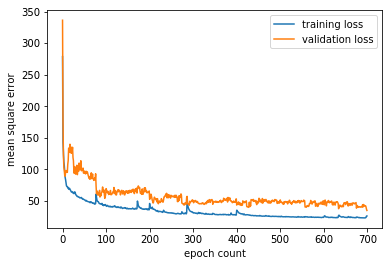

In [7]:
#step 7
#print(dyn_range,np.shape(Xtrain)[0] )
#print(genloss[-1]) #16837.031, 8087.5, 7984.537, 21798.01 21250.178    
if ('history1_1' in locals()) and ('history1' in locals()):
    plt.plot(np.concatenate((history1.history['loss'], history1_1.history['loss'],history2.history['loss'],history2_2.history['loss'], history3.history['loss'], history3_3.history['loss'])), label = 'training loss')
    plt.plot(np.concatenate((history1.history['val_loss'],history1_1.history['val_loss'],  history2.history['val_loss'],history2_2.history['val_loss'], history3.history['val_loss'], history3_3.history['val_loss'])), label = 'validation loss')
elif 'history1' in locals():
    plt.plot(np.concatenate((history1.history['loss'], history2.history['loss'], history3.history['loss'], )), label = 'training loss')
    plt.plot(np.concatenate((history1.history['val_loss'],  history2.history['val_loss'], history3.history['val_loss'], )), label = 'validation loss')    
elif 'history1_1' in locals():
    plt.plot(np.concatenate((history1_1.history['loss'], history2_2.history['loss'], history3_3.history['loss'], )), label = 'training loss')
    plt.plot(np.concatenate((history1_1.history['val_loss'],  history2_2.history['val_loss'], history3_3.history['val_loss'], )), label = 'validation loss')    

    
plt.legend()
plt.xlabel('epoch count')
plt.ylabel('mean square error')

In [7]:
#step 8
from librosa.core import griffinlim

rate=16000
#pre_weights = pretrain.get_weights()
#Train: 6 keyed, 4 cooed, 8 could
#Test: 1212,1049,1064,1197 could, 1208,1179,1118,1247 cud, 1020,1182 keyed, 1070,1035,1111,1189 kid, 1039,1075 cooed, 1053,1134 cod
#for testid=860:1348:

## Strings used for different tests
#mel/MFCC only: _diff_1_stretch_mel_mse_fftlen
#mel same params across three curriculums: _diff_1_stretch_mel_same_mse_fftlen
#spec+mel alternating: _diff_1_stretch_spec_mel_mse_fftlen
#spec+mel together: _diff_1_stretch_spec_mel_mse_together_fftlen
#san
#align

X_out=[]
include_phase=1

if 1:
    generator.load_weights("test_output/"+fname+'_fn_C3.h5')
    bm=1 #bestmodel or not
for i in range(1348): #488
    testid=0+i  #860
    string='_diff_1_spec_mse_fftlen' #same refers to mel params being same for different resolutions
    if bm:
        string=string+'_bestmodel_all3_C3_plainOnly'
    if data_augment:
        string=string+'_augment'
    if normalize_video:
        string = string+'_normVideo'
    
    string=string+options
    
    if include_style:
        reshape_input=np.float16(reshape(np.asarray(Xtrain[testid]),[1,frameCount,2*frameHeight+1]))
    else:
        reshape_input=np.float16(reshape(np.asarray(Xtrain[testid]),[1,frameCount,2*np.shape(landmarks_indices)[0]]))

        

    gen_wave=generator.predict(reshape_input)

    gt_wave=Xtrain_aud[testid]

    #fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
    spec_pred = tf.signal.stft(np.float32(np.transpose(gen_wave[0])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
    X_mag_pred = tf.abs(spec_pred)


    spec_pred_db=10*tf.math.log(X_mag_pred + _LOG_EPS)
    mx=tf.math.reduce_max(spec_pred_db)
    spec_pred_db= tf.clip_by_value(spec_pred_db, mx-dyn_range, mx, name=None)


    spec_phase_true = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[1])), frame_length, frame_step,fft_length=fft_len, pad_end=False)



    spec_true = tf.signal.stft(np.float32(np.transpose(gt_wave)), frame_length, frame_step,fft_length=fft_len, pad_end=False)
    X_mag_true = tf.abs(spec_true)
    spec_true_db=10*tf.math.log(X_mag_true + _LOG_EPS)
    mx=tf.math.reduce_max(spec_true_db)
    spec_true_db= tf.clip_by_value(spec_true_db, mx-dyn_range, mx, name=None)

    if 0:
        plt.subplot(2,2,1)
        plt.imshow(np.transpose(spec_pred_db[0,:,:]),origin='lower', cmap='gray')
        val=np.shape(spec_pred_db)[2]
        plt.yticks(32*np.arange(8),32*np.round(0.5*sr/val)*np.arange(8))

        plt.title('generated '+ 
                  ' pre-empahsis = '+str(apply_pre_emp)+' ' + 
                           'dynamic_range = '+str(dyn_range)+ ' ' +
                           'alpha = '+str(alpha) )
        cbar = plt.colorbar()
        cbar.minorticks_on()

        plt.subplot(2,2,2)
        plt.imshow(np.transpose(spec_true_db[0,:,:]),origin='lower', cmap='gray')
        val=np.shape(spec_true_db)[2]
        plt.yticks(32*np.arange(8),32*np.round(0.5*sr/val)*np.arange(8))
        plt.title('ground truth ' + newlabels[testid][0])
        cbar = plt.colorbar()
        cbar.minorticks_on()
        plt.subplot(2,2,3)
        plt.plot(gen_wave[0])
        plt.title('generated '+ newlabels[testid][0] )

        plt.subplot(2,2,4)
        plt.plot(gt_wave)
        plt.title('ground truth ' + newlabels[testid][0])

        scio.wavfile.write('new_generated_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav',wavfile,gen_wave[0])

    #====================== reconstruct audio from spectrogram using GL method
    if 1:#(include_phase==0):
        st=112
        ed=257
        #(1, 509, 257)
        mag_pred = X_mag_pred[0,:,:].numpy()
        #mag_pred[:,st:ed] = X_mag_true[0,:,st:ed] # try to measure the effect of high formants

        print('test_output/new_gl_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav', newlabels[testid])
        wav_audio = griffinlim(np.transpose(mag_pred), hop_length=frame_step, win_length=frame_length)
        #plt.plot(wav_audio)
        scio.wavfile.write('test_output/new_gl_audio_'+string+str(testid)+'_'+newlabels[testid][0]+'_'+str(st)+str(ed)+'.wav',sr,wav_audio)


        print('test_output/new_fixed_combined_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav', newlabels[testid])


        #============= reconstruction from gt phase
        im= tf.constant([1j], dtype=tf.complex128)
        if 1:
            phase=tf.cast(tf.math.angle(spec_phase_true[0]),dtype=tf.complex128)
        else:
            phase=0;
        mag=tf.cast(X_mag_pred[0], dtype=tf.complex128)

        #take the magnitude of generated spectrum and phase from gt spectrum
        combined = tf.math.multiply(mag, tf.math.exp(im*phase))
        combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
        X_out.append(combined_audio)
        #plt.plot(combined_audio)
        #print(np.shape(combined_audio), combined_audio.dtype)
        scio.wavfile.write('test_output/new_fixed_combined_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())

#scio.wavfile.write('new_orig_audio_'+string+str(testid)+'_'+ newlabels[testid][0]+'.wav',rate,gt_wave)


#Audio(data=gen_wave[0].T, rate=sr)
#Audio(data=wav_audio.T, rate=sr)
#Audio(data=combined_audio.numpy(), rate=sr)
#Audio(data=gt_wave.T, rate=sr)

test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth0_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth0_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth2_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_aud

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth23_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth24_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth24_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth25_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth25_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vide

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth46_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth47_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth47_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth48_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth48_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vide

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth69_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth70_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth70_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth71_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth71_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretc

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth92_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth93_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth93_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth94_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth94_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth115_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth116_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth116_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth117_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth117_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth138_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth139_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth139_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth140_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth140_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth161_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth162_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth162_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth163_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth163_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth184_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth185_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth185_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth186_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth186_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth207_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth208_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth208_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth209_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth209_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth230_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth231_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth231_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth232_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth232_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth253_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth254_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth254_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth255_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth255_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_al

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth276_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth277_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth277_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth278_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth278_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth299_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth300_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth300_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth301_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth301_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth322_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth323_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth323_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth324_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth324_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth345_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth346_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth346_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth347_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth347_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_s

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth368_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth369_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth369_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth370_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth370_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth391_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth392_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth392_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth393_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth393_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth414_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth415_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth415_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth416_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth416_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth437_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth438_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth438_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth439_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth439_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_al

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth460_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth461_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth461_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth462_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth462_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth483_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth484_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth484_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth485_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth485_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth506_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth507_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth507_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth508_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth508_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_al

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth529_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth530_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth530_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth531_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth531_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth552_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth553_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth553_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth554_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth554_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth575_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth576_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth576_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth577_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth577_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth598_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth599_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth599_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth600_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth600_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth621_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth622_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth622_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth623_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth623_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth644_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth645_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth645_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth646_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth646_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth667_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth668_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth668_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth669_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth669_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth690_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth691_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth691_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth692_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth692_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_al

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth713_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth714_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth714_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth715_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth715_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth736_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth737_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth737_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth738_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth738_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth759_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth760_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth760_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth761_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth761_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth782_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth783_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth783_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth784_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth784_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vid

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth805_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth806_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth806_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth807_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth807_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth828_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth829_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth829_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth830_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth830_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth851_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth852_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth852_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth853_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth853_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth874_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth875_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth875_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth876_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth876_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_al

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth897_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth898_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth898_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth899_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth899_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_al

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth920_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth921_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth921_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth922_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth922_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligne

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth943_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth944_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth944_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth945_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth945_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_al

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth966_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth967_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth967_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth968_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth968_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_in

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth989_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth990_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth990_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth991_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth991_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1012_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1013_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1013_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1014_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1014_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_i

test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1035_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1035_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1036_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1036_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1037_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vi

test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1058_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1058_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1059_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1059_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1060_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vi

test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1081_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1081_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1082_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1082_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1083_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_a

test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1104_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1104_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1105_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1105_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1106_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vi

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1126_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1127_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1127_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1128_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1128_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_vi

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1149_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1150_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1150_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1151_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1151_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_inter

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1172_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1173_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1173_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1174_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1174_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_inter

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1195_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1196_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1196_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1197_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1197_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_a

test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1218_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1218_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1219_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1219_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1220_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_a

test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1241_cod.wav ['cod']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1241_cod.wav ['cod']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1242_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1242_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1243_cooed.wav ['cooed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_align

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1264_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1265_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1265_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1266_kid.wav ['kid']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1266_kid.wav ['kid']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_align

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1287_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1288_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1288_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1289_cud.wav ['cud']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1289_cud.wav ['cud']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_inter

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1310_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1311_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1311_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1312_could.wav ['could']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1312_could.wav ['could']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOn

test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1333_cooed.wav ['cooed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1334_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1334_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1335_keyed.wav ['keyed']
test_output/new_fixed_combined_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOnly_aligned_interp_video_stretch_audio_mouthonly_832_framecount_80_melW_0__mouth1335_keyed.wav ['keyed']
test_output/new_gl_audio__diff_1_spec_mse_fftlen_bestmodel_all3_C3_plainOn

In [9]:
np.shape(Xtrain)

(1349, 80, 58)

Text(0.5, 1.0, 'Comparison of Ground truth wave and after GL method')

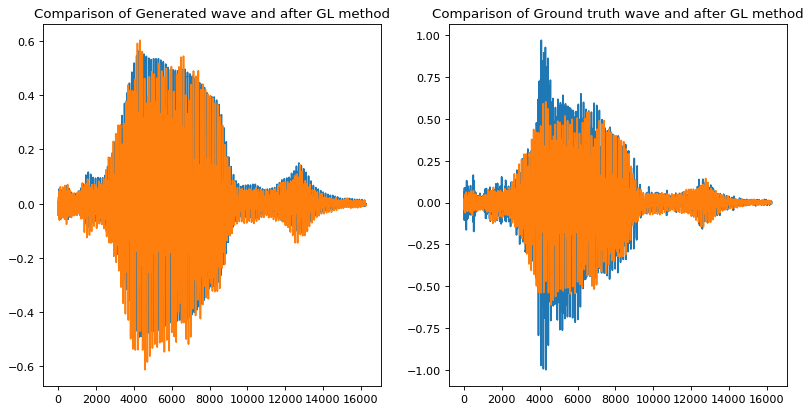

In [27]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(gen_wave[0,0:np.shape(wav_audio)[0],0])
plt.plot(wav_audio)
plt.title('Comparison of Generated wave and after GL method')
plt.subplot(1,2,2)

plt.plot(gt_wave[0:np.shape(wav_audio)[0]])
plt.plot(wav_audio)
plt.title('Comparison of Ground truth wave and after GL method')
#print(np.shape(gen_wave), np.shape(wav_audio), np.shape(gt_wave))


Text(0.5, 1.0, 'Plain only training')

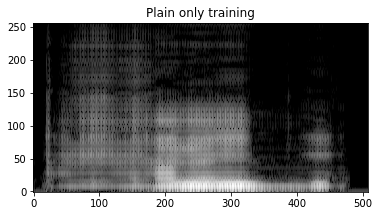

In [9]:
#plt.plot(wav_audio)

mag_pred = X_mag_pred[0,:,:].numpy()
mag_pred[:,st:ed] = X_mag_pred[0,:,st:ed]
high_db=10*tf.math.log(mag_pred + _LOG_EPS)
mx=tf.math.reduce_max(high_db)
spec_high_db= tf.clip_by_value(high_db, mx-dyn_range, mx, name=None)

plt.imshow(np.transpose(spec_high_db),origin='lower', cmap='gray')
plt.title('Plain only training')



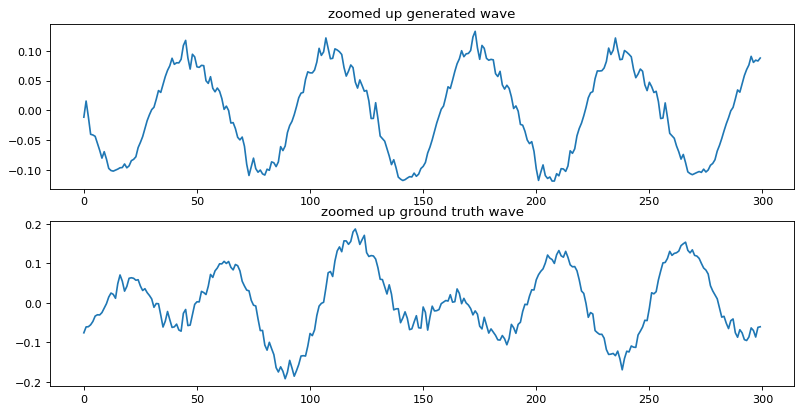

In [16]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(gen_wave[0,4000:4300])
plt.title('zoomed up generated wave')
plt.subplot(2,1,2)
plt.title('zoomed up ground truth wave')
plt.plot(gt_wave[4000:4300])

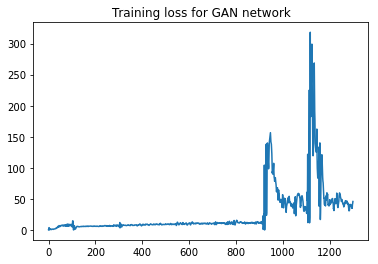

In [70]:
x=[]
gloss=[]
dlossf=[]
dlossr=[]
bs=2*batch_size
for s in range(1300):
    #randomly sample videos from training data
    #idx=np.random.randint(0,np.shape(Xtrain)[0]-1,size=batch_size)
    idx=np.random.randint(1,1000,size=bs)
    #print(idx)
    Xtrain_aud_bs=np.asarray(Xtrain_aud)[idx]
    Xtrain_vid_bs=np.asarray(Xtrain)[idx,:,:]
    
    #generate fake for disc training
    vid_input=np.float32(Xtrain_vid_bs)
    generated_audio= generator.predict(vid_input)

    #train discriminator
    X=np.concatenate((Xtrain_aud_bs, generated_audio))
    valid = np.ones((bs, 1))
    fake = np.zeros((bs, 1))
    
    #y = np.zeros([2*batch_size,1])
    #y[0:batch_size,0] = 1 # real audio
    #y[batch_size:,0] = 0  #fake generated audio
    discriminator.trainable=True
    d_loss_real = discriminator.train_on_batch(Xtrain_aud_bs, valid)
    d_loss_fake = discriminator.train_on_batch(generated_audio, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    #d_loss  = discriminator.train_on_batch(X,y)
    dlossf.append(d_loss_fake)
    dlossr.append(d_loss_real)
    #train GAN with generator being trainable and fixed discriminator params
    #y1 = np.ones([batch_size,1])
    #GAN.layers[1].trainable=True #generator
    #GAN.layers[2].trainable=False #discriminator
    discriminator.trainable = False
    g_loss = GAN.train_on_batch(Xtrain_vid_bs,valid)
    
    #ypred=GAN.predict(Xtrain[idx,:,:])
    #print(np.transpose(ypred))
    #print(g_loss)
    x.append(s)
    gloss.append(g_loss)
    clear_output(wait=True)
    plt.plot(x, gloss, label="GAN loss")
    #plt.hold(True)
    #plt.plot(x, dlossr, label="Disc loss real")
    #plt.plot(x, dlossf, label="Disc loss fake")
    plt.title("Training loss for GAN network")
    plt.show()

In [54]:
print(np.shape(gloss))

(200,)


['keyed']


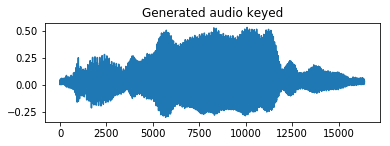

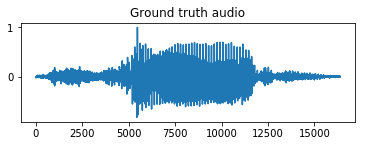

In [75]:
#generate predictions

rate=16000
#pre_weights = pretrain.get_weights()
testid=6
#reshape_input=np.float16(reshape(np.array(Xtrain[testid,:]),[1,frameCount,2*frameHeight]))
reshape_input=np.float16(reshape(np.asarray(Xtrain[testid]),[1,frameCount,2*frameHeight]))


label= GAN.predict(reshape_input)

print(newlabels[testid])

intermediate_model=GAN.get_layer('gener') #generator
intermediate_prediction2=intermediate_model.predict(reshape_input)


scio.wavfile.write('generated_gan_100_'+newlabels[testid][0]+'.wav',sr,intermediate_prediction2[0])

plt.subplot(2,1,1)
plt.plot(intermediate_prediction2[0])
plt.title('Generated audio ' + newlabels[testid][0])
plt.show()
plt.subplot(2,1,2)
plt.plot(Xtrain_aud[testid])
plt.title('Ground truth audio')
plt.show()
#plt.subplot(3,1,3)
#plt.title('Video Encodings')
#plt.plot(Xtrain[testid])
#plt.show()


(1349, 80, 58) (1349, 80, 58)
(1348, 1)


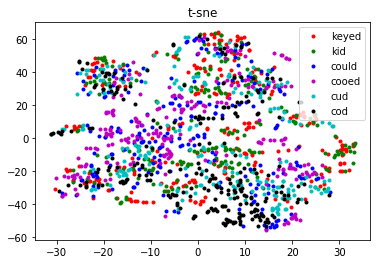

In [4]:
from sklearn.manifold import TSNE
#(107, 45, 64, 64, 2)<-xtrain shape

X=np.nan_to_num(Xtrain)
print(np.shape(Xtrain), np.shape(X))
if 0:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]*np.shape(X)[3]*np.shape(X)[4]))
else:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]))
    #np.where(np.isnan(Xtrain))

labels_emb=newlabels[0:np.shape(X)[0]-1,:]
print(np.shape(labels_emb))
v_embedded = TSNE(n_components=2).fit_transform(X_reshaped)

clrs=['r','g','b','m', 'c', 'k' ]

for i, c in enumerate( ['keyed','kid','could', 'cooed', 'cud', 'cod' ] ):
    q = np.where( labels_emb == c )[0]     
    plt.plot( v_embedded[q,0], v_embedded[q,1],'.', color=clrs[i], label=c )
    
plt.legend()
plt.title('t-sne')
plt.savefig( 'tsne-embedding.png' )


(1349, 80, 58) (800, 80, 58)


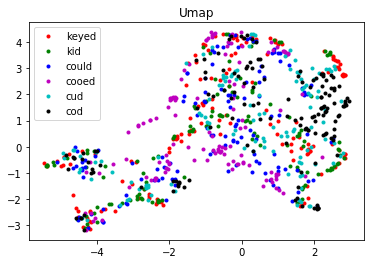

In [31]:
#plot using umap
#!pip install umap-learn
import umap

X=np.nan_to_num(Xtrain[0:800])
print(np.shape(Xtrain), np.shape(X))
if 0:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]*np.shape(X)[3]*np.shape(X)[4]))
else:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]))
    #np.where(np.isnan(Xtrain))

labels_emb=newlabels[0:np.shape(X)[0]-1,:]

embeddings = dict()
embeddings['umap'] = umap.UMAP().fit_transform( X_reshaped ) 

for i, c in enumerate( ['keyed','kid','could', 'cooed', 'cud', 'cod' ] ):
    q = np.where( labels_emb == c )[0]
    plt.plot(embeddings['umap'][q,0], embeddings['umap'][q,1], '.', color=clrs[i],label=c)
plt.title('Umap')    
plt.legend()



In [10]:
#plot using umap on output data
#!pip install umap-learn
import umap


#X=np.nan_to_num(X_out[0:800])
X= X_out[0:800]
print(np.shape(X_out), np.shape(X))

if 0:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]*np.shape(X)[2]*np.shape(X)[3]*np.shape(X)[4]))
else:
    X_reshaped = np.reshape(X, (np.shape(X)[0], np.shape(X)[1]))
    #np.where(np.isnan(Xtrain))

labels_emb=newlabels[0:np.shape(X)[0]-1,:]

embeddings = dict()
embeddings['umap'] = umap.UMAP().fit_transform( X_reshaped ) 

for i, c in enumerate( ['keyed','kid','could', 'cooed', 'cud', 'cod' ] ):
    q = np.where( labels_emb == c )[0]
    plt.plot(embeddings['umap'][q,0], embeddings['umap'][q,1], '.', color=clrs[i],label=c)
plt.title('Umap')    
plt.legend()




KeyboardInterrupt: 

In [11]:
np.save('X_out', X_out)

KeyboardInterrupt: 

In [38]:
print(np.where(embeddings['umap'][:,0]>6))
print(np.where(embeddings['umap'][:,1]<-5))


#696 to 795
print(np.intersect1d(np.where(embeddings['umap'][:,0]>2), np.where(embeddings['umap'][:,1]>4)))


print(np.intersect1d(np.where(v_embedded[:,0]>30), np.where(v_embedded[:,1]>20)))


filelist[858]

(array([], dtype=int64),)
(array([], dtype=int64),)
[ 454  593  695  696  697  698  705  706  708  709  715  716  717  718
  721  727  730  731  732  734  735  736  737  738  739  741  742  743
  744  750  751  752  754  755  757  760  761  762  763  764  765  766
  767  768  769  771  774  775  776  778  779  780  781  783  784  785
  786  789  790  791  792  794  795  797  798  799  800  801  804  805
  807  808  809  810  811  812  813  814  815  816  817  818  819  820
  821  822  823  824  825  826  829  830  831  832  833  834  835  837
  838  839  841  844  845  846  847  848  849  851  852  853  854  855
  856  857  858 1245]
[ 327  328  343  348  349  353  380  419  420  431  978 1064 1071 1074
 1093 1119 1174]


'scratch/avc/lisa_data_opt/1106/1106_part3_kid_20813.0_20851.0_mouth'

In [ ]:
#debug step
np.shape(np.transpose(Xtrain_aud[5,:,:]))
frame_length=512
frame_step=256
#fft_len=512
waveform=Xtrain_aud[3,:,:]
spec_pred = tf.signal.stft(np.float32(np.transpose(waveform)), frame_length, frame_step, pad_end=True)
X_mag_pred = tf.abs(spec_pred)
spec_pred_db=tf.math.log(X_mag_pred + _LOG_EPS)
np.shape(spec_pred_db)
plt.imshow(spec_pred_db[0,:,:])

# try reconstructing audio from spectrogram stft
inverse_stft = tf.signal.inverse_stft(
    spec_pred, frame_length, frame_step,
    window_fn=tf.signal.inverse_stft_window_fn(frame_step))

print(np.shape(inverse_stft))
plt.subplot(2,1,1)
plt.plot(inverse_stft[0,:])
plt.subplot(2,1,2)
plt.plot(waveform)

In [ ]:
#ypred=GAN.predict(Xtrain[idx,:,:,:,:])
#print(ypred)
print(GAN.layers[2].name)



sr=16000
rate=sr

_LOG_EPS = 1e-6
frame_length= 128 # np.int32(sr*0.005) #window len - 80
frame_step=np.int32(np.round(sr*0.002)) # time step -32 - increase value decreases x ticks - 0.002 or 0.006
fft_len=512 # increase value increases y ticks 
epochs=2500
fac = fft_len/16

testid=6
gtid=7
print(newlabels[testid], newlabels[gtid])
### reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
X_mag_gtid = tf.math.abs(spec_gtid)   
im= tf.constant([1j], dtype=tf.complex128)
phase_testid=tf.cast(tf.math.angle(spec_testid[0]),dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)
phase_gtid=tf.cast(tf.math.angle(spec_gtid[0]),dtype=tf.complex128)
mag_gtid=tf.cast(X_mag_gtid[0], dtype=tf.complex128)


#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio)
scio.wavfile.write('phase_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())

### reconstruction from phase of same person different token
testid=6
gtid=8
print(newlabels[testid], newlabels[gtid])
# reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
X_mag_gtid = tf.math.abs(spec_gtid)   
im= tf.constant([1j], dtype=tf.complex128)
phase_testid=tf.cast(tf.math.angle(spec_testid[0]),dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)
phase_gtid=tf.cast(tf.math.angle(spec_gtid[0]),dtype=tf.complex128)
mag_gtid=tf.cast(X_mag_gtid[0], dtype=tf.complex128)


#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio)
scio.wavfile.write('phase_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())


#reconstruction from phase of another person same token
testid=6
gtid=406
print(newlabels[testid], newlabels[gtid])
# reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
X_mag_gtid = tf.math.abs(spec_gtid)   
im= tf.constant([1j], dtype=tf.complex128)
phase_testid=tf.cast(tf.math.angle(spec_testid[0]),dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)
phase_gtid=tf.cast(tf.math.angle(spec_gtid[0]),dtype=tf.complex128)
mag_gtid=tf.cast(X_mag_gtid[0], dtype=tf.complex128)


#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio)
scio.wavfile.write('phase_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())




#reconstruction from phase of another person another token
testid=6
gtid=402
print(newlabels[testid], newlabels[gtid])
# reconstruction from phase of same person same token
spec_testid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[testid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
spec_gtid = tf.signal.stft(np.float32(np.transpose(Xtrain_aud[gtid])), frame_length, frame_step,fft_length=fft_len, pad_end=False)
X_mag_testid = tf.math.abs(spec_testid)   
X_mag_gtid = tf.math.abs(spec_gtid)   
im= tf.constant([1j], dtype=tf.complex128)
phase_testid=tf.cast(tf.math.angle(spec_testid[0]),dtype=tf.complex128)
mag_testid=tf.cast(X_mag_testid[0], dtype=tf.complex128)
phase_gtid=tf.cast(tf.math.angle(spec_gtid[0]),dtype=tf.complex128)
mag_gtid=tf.cast(X_mag_gtid[0], dtype=tf.complex128)


#take the magnitude of generated spectrum and phase from gt spectrum
combined = tf.math.multiply(mag_testid, tf.math.exp(im*phase_gtid))
combined_audio = tf.math.real(tf.signal.inverse_stft(combined, frame_length, frame_step, fft_len))
plt.figure()
plt.subplot(2,1,1)
plt.plot(Xtrain_aud[testid])
plt.subplot(2,1,2)
plt.plot(combined_audio)
scio.wavfile.write('phase_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,combined_audio.numpy())

Audio(data=combined_audio.numpy(), rate=sr)

scio.wavfile.write('phase_orig_audio_'+str(gtid)+'_'+str(testid)+'_'+ newlabels[gtid][0]+'_'+ newlabels[testid][0]+'.wav',rate,Xtrain_aud[testid])




In [ ]:
import parselmouth
from parselmouth.praat import call

afile=filelist[7]+'_audio.wav'

sound = parselmouth.Sound(afile)
aud=sound.values.T

wavfile.write('audio_stretched_orig_keyed_praat_audio.wav',sr,aud)

aud, index=effects.trim(np.float32(aud), top_db=freq)
aud=np.append(aud,np.zeros([1024]))
print(np.shape(sound.values), np.shape(aud.T))
sound = parselmouth.Sound(aud.T, sampling_frequency=sr)
#create manipulation object
manipulation = call(sound, "To Manipulation",0.01, 75, 600)

##extract durationtier and add a duration point
duration_tier = call(manipulation, "Extract duration tier")
duration = call(duration_tier, "Add point", sound.duration, shp/(np.shape(aud)[0]*1.0))

#replace the duration tier in the manipulation object
call([duration_tier, manipulation], "Replace duration tier")

#Publish resynthesis
sound_octave_up = call(manipulation, "Get resynthesis (overlap-add)")
#sound_octave_up.save("4_b_octave_up.wav", "WAV")

print(afile, sound.duration, sound_octave_up.duration, shp,np.shape(aud)[0],sound_octave_up.sampling_frequency)
np.shape(sound_octave_up.values.T)


aud=sound_octave_up.values.T

wavfile.write('audio_stretched_keyed_praat_audio.wav',sr,aud)

aud=scaler_std.fit_transform(aud)
aud=scaler_max.fit_transform(aud)


wavfile.write('audio_stretched_scaled_keyed_praat_audio.wav',sr,aud)
Audio(data=aud.T, rate=sr)

In [ ]:
#check audio stretch affects the quality of sound.
testid=6
afile=filelist[testid]+'_audio.wav'
sr,aud = wavfile.read(afile)
stretched =effects.time_stretch(np.float32(aud), np.shape(aud)[0]/shp)
reshaped=np.reshape(stretched[0:shp],(shp,1))

scaled1=scaler_std.fit_transform(reshaped)
scaled2=scaler_max.fit_transform(scaled1)

wavfile.write('audio_'+newlabels[testid][0]+'_raw_audio.wav',sr,aud)
wavfile.write('audio_'+newlabels[testid][0]+'_stretched.wav',sr,stretched)
wavfile.write('audio_'+newlabels[testid][0]+'_scaled1.wav',sr,scaled1)
wavfile.write('audio_'+newlabels[testid][0]+'_scaled2.wav',sr,scaled2)


psr,pitchread = wavfile.read('1101_part1_keyed_22012_0_22053_0_mouth_audio_140band.wav')
gsr,glread = wavfile.read('gl_audio_keyed_128257.wav')

shp2=np.shape(glread)[0]
pstretched =effects.time_stretch(np.float32(pitchread), np.shape(pitchread)[0]/shp2)

reshaped=np.reshape(pstretched[0:shp2],(shp2,1))
scaled1=scaler_std.fit_transform(reshaped)
scaled2=scaler_max.fit_transform(scaled1)



print(np.shape(scaled2), np.shape(glread))

pitchadded = glread+1*scaled2[:,0]
wavfile.write('audio_'+newlabels[testid][0]+'_pitch_added_100.wav',sr,pitchadded)

plt.subplot(3,1,1)
plt.plot(glread)

plt.subplot(3,1,2)
plt.plot(0.1*scaled2[:,0])

plt.subplot(3,1,3)
plt.plot(pitchadded)

In [ ]:
#trim audio

#subj=str((1101+1))
#i=1
#afile=join('scratch/avc/lisa_data/'+subj+'/',filelist[i][0:-4]+'_audio.wav')
#sr,aud = wavfile.read(afile)
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')

#for i in range(15):
#    waveform=Xtrain_aud[i]
#    mfccs= feature.mfcc(waveform[:,0], sr=sr,n_mfcc=30)
#    S = feature.melspectrogram(y=waveform[:,0], sr=sr, n_mels=32,fmax=8000)
#    plt.subplot(5,5,i+1)
#    plt.imshow(mfccs)
    
for no in range(15):
    sno=no+0
    waveform, index=effects.trim(Xtrain_aud[sno][:,0], top_db=25)
    #print(np.shape(waveform), np.shape(Xtrain_aud[sno][:,0]))
    waveform=Xtrain_aud[sno][index[0]:index[1]]
    plt.subplot(5,5,no+1)
    plt.plot(waveform)
    plt.title(newlabels[sno])